In [1]:
import numpy as np
import seaborn as sns
import torch
import random
import pathlib
import os
import glob
from matplotlib import pyplot as plt
import pandas as pd
from skimage.transform import resize
from tqdm import tqdm
import torch.nn.functional as F

from PraNet.utils.dataloader import test_dataset
from PraNet.lib.PraNet_Res2Net import PraNet
from skimage.filters import gaussian
from skimage.morphology import label as connected_components

In [2]:
# !rm -r ./.cache

In [3]:
def fix_randomness(seed=0):
    np.random.seed(seed=seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)

In [4]:
"""
    Code for the local maximum version of the method.
"""
from skimage.morphology import reconstruction
from skimage.measure import regionprops
def find_peaks(sigmoid):
    sigmoid = gaussian(sigmoid,0.5)
    seed = np.copy(sigmoid)
    seed[1:-1, 1:-1] = sigmoid.min()
    mask = sigmoid
    dilated = reconstruction(seed, mask, method='dilation')
    peaks = (sigmoid - dilated)
    binarized_peaks = peaks > 0.05
    labels, num_components = connected_components(binarized_peaks, background=0, return_num=True, connectivity=2)
    proposals = regionprops(labels, intensity_image=None, cache=True)
    normalization_value = np.ones_like(peaks)
    minsize = 25 
    for region in proposals:
        # take regions with large enough areas
        if region.area >= minsize:
        # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            minr = max(minr-minsize, 0)
            minc = max(minc-minsize, 0)
            maxr = min(maxr+minsize, normalization_value.shape[0]-1)
            maxc = min(maxc+minsize, normalization_value.shape[1]-1)
            np.minimum(normalization_value[minr:maxr, minc:maxc], peaks[minr:maxr, minc:maxc].max(), out = normalization_value[minr:maxr, minc:maxc])
    peaks = np.maximum(sigmoid, peaks/normalization_value)

    return peaks


In [5]:
def get_num_examples(folders):
    num = 0
    for folder in folders:
        num += len([name for name in os.listdir(folder + '/images/')])
    return num

def get_data(cache_path):
    #base model path
    model_path = './PraNet/snapshots/PraNet_Res2Net/PraNet-19.pth'
    #image size
    test_size = 352
    T = 10 
    folders = ['HyperKvasir', 'CVC-300', 'CVC-ClinicDB', 'Kvasir', 'CVC-ColonDB', 'ETIS-LaribPolypDB']
    folders = ['./PraNet/data/TestDataset/' + x for x in folders]

    try:
        img_names = np.load(cache_path + 'img_names.npy')
        sigmoids = np.load(cache_path + 'sigmoids.npy')
        masks = np.load(cache_path + 'masks.npy')
        regions = np.load(cache_path + 'regions.npy')
        num_components = np.load(cache_path + 'num_components.npy')
        print(f'Loaded {sigmoids.shape[0]} labeled examples from cache.')
    except:
        #calculate number of images
        num_examples = get_num_examples(folders)
        print(f'Caching {num_examples} labeled examples.')
        img_names = ['']*num_examples
        sigmoids = np.zeros((num_examples,test_size, test_size))
        masks = np.zeros((num_examples,   test_size, test_size))
        regions = np.zeros((num_examples, test_size, test_size))
        num_components = np.zeros((num_examples,))
        
        k = 0
        for data_path in folders:
            model = PraNet()
            model.load_state_dict(torch.load(model_path))
            model.cuda()
            model.eval()

            os.makedirs(cache_path, exist_ok=True)
            image_root = '{}/images/'.format(data_path)
            gt_root = '{}/masks/'.format(data_path)
            test_loader = test_dataset(image_root, gt_root, test_size)

            for i in range(test_loader.size):
                image, gt, name = test_loader.load_data()
                print(f"\33[2K\r Processing {name}", end="")
                gt = np.asarray(gt, np.float32)
                gt /= (gt.max() + 1e-8)
                image = image.cuda()

                res5, res4, res3, res2 = model(image)
                
                # Populate the arrays
                img_names[k] = image_root + '/' + name
                sigmoids[k,:,:] = (res2/T).sigmoid().detach().cpu().numpy()
                temp_mask = resize(gt, (test_size, test_size), anti_aliasing=False)
                #temp_mask = area_opening(temp_mask, area_threshold=10, connectivity=2)
                #temp_mask = area_closing(temp_mask, area_threshold=10, connectivity=2)
                temp_mask = gaussian(temp_mask, sigma=1, multichannel=True)
                temp_mask[temp_mask > 0.5] = 1
                masks[k,:,:], num_components[k] = connected_components(temp_mask, background=0, return_num=True, connectivity=2)
                regions[k,:,:] = find_peaks(sigmoids[k,:,:])
                k += 1
        os.makedirs(cache_path, exist_ok=True)
        np.save(cache_path + 'sigmoids', sigmoids)
        np.save(cache_path + 'img_names', img_names)
        np.save(cache_path + 'masks', masks)
        np.save(cache_path + 'regions', regions)
        np.save(cache_path + 'num_components', num_components)
    return np.array(img_names), torch.tensor(sigmoids), torch.tensor(masks),torch.tensor(regions), torch.tensor(num_components)

In [6]:
def get_example_loss_and_size_tables(regions, masks, lambdas_example_table, num_calib):
    lam_len = len(lambdas_example_table)
    lam_low = min(lambdas_example_table)
    lam_high = max(lambdas_example_table)
    fname_loss = f'.cache/{lam_low}_{lam_high}_{lam_len}_example_loss_table.npy'
    fname_sizes = f'.cache/{lam_low}_{lam_high}_{lam_len}_example_size_table.npy'
    try:
        loss_table = np.load(fname_loss)
        sizes_table = np.load(fname_sizes)
    except:
        print("computing loss and size table")
        loss_table = np.zeros((regions.shape[0], lam_len))
        sizes_table = np.zeros((regions.shape[0], lam_len))
        for j in tqdm(range(lam_len)):
            est_regions = (regions >= -lambdas_example_table[j])
            print(type(est_regions),est_regions.shape,masks.shape)
            loss_table[:,j] = loss_perpolyp_01(est_regions, regions, masks) 
            sizes_table[:,j] = est_regions.sum(dim=1).sum(dim=1)/masks.sum(dim=1).sum(dim=1)

        np.save(fname_loss, loss_table)
        np.save(fname_sizes, sizes_table)


        return loss_table, sizes_table

In [ ]:
img_names, sigmoids, masks, regions, num_components = get_data(cache_path)
est_regions = (regions >= -lambdas_example_table[0])
# # est_regions
# # ,regions, 
# # plt.imshow(masks[0],cmap='gray')
# # plt.colorbar()
# # masks[0]
T=est_regions

risk_mass=regions
num_polyps = masks.max(dim=1)[0].max(dim=1)[0]
missed = ((masks>0).to(int) - T.to(int)) # as lambda grows, the sets grow.
F.relu(missed, inplace=True) 
missed = missed * masks
results_perpolyp = torch.zeros((num_polyps.sum().int().item(), \
                                masks.shape[1], masks.shape[2]))
masks_perpolyp = torch.zeros_like(results_perpolyp)
k = 0
for n in range(num_polyps.max().int().item()):
    filter_bool = (num_polyps >= n + 1) # 1, 2, 3 polyps 
    temp_missed = missed[filter_bool]
    print(temp_missed.shape)
    temp_masks = masks[filter_bool]
    results_perpolyp[k:k+temp_missed.shape[0]] = (temp_missed == n + 1)
    masks_perpolyp[k:k+temp_missed.shape[0]] = (temp_masks == n+1)
    k += temp_missed.shape[0] 
    
#     break
#     print(n)
# masks.unique()
# num_polyps

In [21]:
temp_missed.shape

torch.Size([898, 352, 352])

In [7]:
def loss_perpolyp_01(T, risk_mass, masks): # lambda in [-1,0]
    # Get the missed pixels 
    num_polyps = masks.max(dim=1)[0].max(dim=1)[0]
    missed = ((masks>0).to(int) - T.to(int)) # as lambda grows, the sets grow.
    F.relu(missed, inplace=True) 
    # Split the different polyps into different rows.
    missed = missed * masks
    results_perpolyp = torch.zeros((num_polyps.sum().int().item(), \
                                    masks.shape[1], masks.shape[2]))
    masks_perpolyp = torch.zeros_like(results_perpolyp)
    k = 0
    for n in range(num_polyps.max().int().item()):
        filter_bool = (num_polyps >= n + 1) # 1, 2, 3 polyps 
        temp_missed = missed[filter_bool]
        temp_masks = masks[filter_bool]
        results_perpolyp[k:k+temp_missed.shape[0]] = (temp_missed == n + 1)
        masks_perpolyp[k:k+temp_missed.shape[0]] = (temp_masks == n+1)
        k += temp_missed.shape[0] 
    results_perpolyp = results_perpolyp.to(float).sum(dim=1).sum(dim=1)/masks_perpolyp.sum(dim=1).sum(dim=1)    
    return results_perpolyp

In [8]:
def trial_precomputed(example_loss_table, example_size_table, alpha, num_calib, num_lam, lambdas_example_table):
    total=example_loss_table.shape[0]
    perm = torch.randperm(example_loss_table.shape[0])
    example_loss_table = example_loss_table[perm]
    example_size_table = example_size_table[perm]
    calib_losses, val_losses = (example_loss_table[0:num_calib], example_loss_table[num_calib:])
    calib_sizes, val_sizes = (example_size_table[0:num_calib], example_size_table[num_calib:])

    lhat = get_lhat(calib_losses[:,::-1], lambdas_example_table[::-1], alpha)

    losses = val_losses[:,np.argmax(lambdas_example_table == lhat)]
    #print(lhat,losses)
    size = np.random.choice(val_sizes[:,np.argmax(lambdas_example_table == lhat)])

    return lhat, losses.mean(), size

In [9]:
 np.random.choice([[9],[7],[5]])

ValueError: a must be 1-dimensional

In [9]:
def get_lhat(calib_loss_table, lambdas, alpha, B=1):
    n = calib_loss_table.shape[0]
    rhat = calib_loss_table.mean(axis=0)
#     print()
    lhat_idx = max(np.argmax(((n/(n+1)) * rhat + B/(n+1)) >= alpha) - 1, 0) # Can't be -1.
    #print(lhat_idx, lambdas[lhat_idx])
    return lambdas[lhat_idx]


In [10]:
def experiment(alpha, num_trials, num_calib, num_lam, output_dir, lambdas_example_table):
    img_names, sigmoids, masks, regions, num_components = get_data(cache_path)
    masks[masks > 1] = 1
    fname = cache_path + f'{alpha}_{num_calib}_{num_lam}_dataframe'.replace('.','_') + '.pkl'

    df = pd.DataFrame(columns=['$\\hat{\\lambda}$','risk','sizes','alpha'])
    try:
        print('Dataframe loaded')
        df = pd.read_pickle(fname)
    except:
        example_loss_table, example_sizes_table = get_example_loss_and_size_tables(regions, masks, \
                                                                                   lambdas_example_table, \
                                                                                   num_calib)

        local_df_list = []
        for i in tqdm(range(num_trials)):
            lhat, risk, sizes = trial_precomputed(example_loss_table, example_sizes_table, alpha, num_calib, num_lam, lambdas_example_table)
                
            dict_local = {"$\\hat{\\lambda}$": lhat, "risk": risk, "sizes": sizes, "alpha": alpha}
            df_local = pd.DataFrame(dict_local, index=[i])
            local_df_list = local_df_list + [df_local]
        df = pd.concat(local_df_list, axis=0, ignore_index=True)
        df.to_pickle(fname)

    return df

In [13]:
# df
cache_path = './.cache/'
output_dir = 'outputs/histograms/'
pathlib.Path(cache_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

num_trials = 1000
num_calib = 500
num_lam = 500
alpha = 0.1
lambdas_example_table = np.linspace(-1,0,500)

fname = './.cache' + f'{alpha}_{num_calib}_{num_lam}_dataframe'.replace('.','_') + '.pkl'


(array([830.,  71.,  14.,  15.,  11.,  12.,   6.,   7.,   8.,   6.,   3.,
          0.,   2.,   0.,   2.,   1.,   2.,   1.,   2.,   1.,   0.,   2.,
          2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([2.07870947e-02, 6.17716381e+00, 1.23335405e+01, 1.84899172e+01,
        2.46462939e+01, 3.08026707e+01, 3.69590474e+01, 4.31154241e+01,
        4.92718008e+01, 5.54281775e+01, 6.15845542e+01, 6.77409309e+01,
        7.38973076e+01, 8.00536844e+01, 8.62100611e+01, 9.23664378e+01,
        9.85228145e+01, 1.04679191e+02, 1.10835568e+02, 1.16991945e+02,
        1.23148321e+02, 1.29304698e+02, 1.35461075e+02, 1.41617451e+02,
        1.47773828e+02, 1.53930205e+02, 1.60086582e+02, 1.66242958e+02,
        1.72399335e+02, 1.78555712e+02, 1.84712088e+02, 1.90868465e+02,
        1.9702

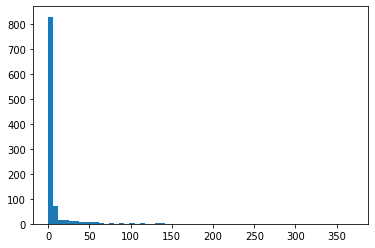

In [21]:
df = pd.read_pickle('./.cache/0_1_500_500_dataframe.pkl')
plt.hist(df['sizes'],bins=60)

In [11]:
def plot_histograms(df, alpha, output_dir):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
    axs[0].hist(df['risk'].to_numpy(), alpha=0.7, density=True)

    normalized_size = df['sizes'].to_numpy()
    axs[1].hist(normalized_size, bins=60, alpha=0.7, density=True)

    axs[0].set_xlabel('risk')
    axs[0].locator_params(axis='x', nbins=10)
    axs[0].axvline(x=alpha,c='#999999',linestyle='--',alpha=0.7)
    axs[0].set_ylabel('density')
    axs[1].set_xlabel('set size as a fraction of polyp size')
    axs[1].locator_params(axis='x', nbins=10)
    axs[1].set_yscale('log')
    #axs[1].legend()
    sns.despine(top=True, right=True, ax=axs[0])
    sns.despine(top=True, right=True, ax=axs[1])
    plt.tight_layout()
    plt.savefig( output_dir + (f'{alpha}_polyp_histograms').replace('.','_') + '.pdf'  )
    print(f"The mean and standard deviation of the risk over {len(df)} trials are {df['risk'].mean()} and {df['risk'].std()} respectively.")

Loaded 898 labeled examples from cache.
Dataframe loaded
The mean and standard deviation of the risk over 1000 trials are 0.09813213885815358 and 0.018098664876062882 respectively.


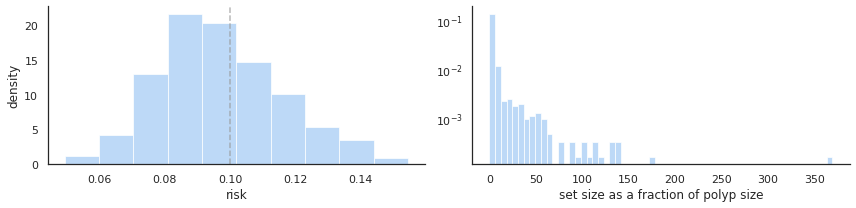

In [12]:
with torch.no_grad():
        sns.set(palette='pastel', font='serif')
        sns.set_style('white')
        fix_randomness()

        cache_path = './.cache/'
        output_dir = 'outputs/histograms/'
        pathlib.Path(cache_path).mkdir(parents=True, exist_ok=True)
        pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

        num_trials = 1000
        num_calib = 500
        num_lam = 500
        alpha = 0.1
        lambdas_example_table = np.linspace(-1,0,500)

        df = experiment(alpha, num_trials, num_calib, num_lam, output_dir, lambdas_example_table)
        plot_histograms(df, alpha, output_dir)


In [13]:
df = experiment(alpha, num_trials, num_calib, num_lam, output_dir, lambdas_example_table)

Loaded 898 labeled examples from cache.
Dataframe loaded


In [14]:
img_names, sigmoids, masks, regions, num_components = get_data(cache_path)
# masks[masks > 1] = 1
# fname = cache_path + f'{alpha}_{num_calib}_{num_lam}_dataframe'.replace('.','_') + '.pkl'
# df = pd.DataFrame(columns=['$\\hat{\\lambda}$','risk','sizes','alpha'])
# try:
#     print('Dataframe loaded')
#     df = pd.read_pickle(fname)
# except:
# example_loss_table, example_sizes_table = get_example_loss_and_size_tables(regions, masks, \
#                                                                                lambdas_example_table, \
#                                                                                    num_calib)

Loaded 898 labeled examples from cache.


In [19]:
masks.unique()

tensor([0., 1.], dtype=torch.float64)

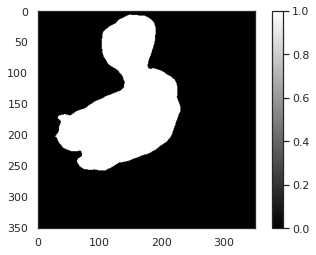

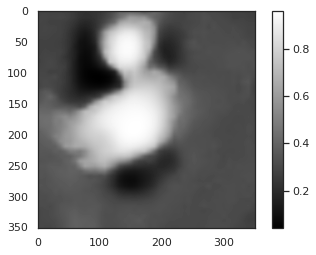

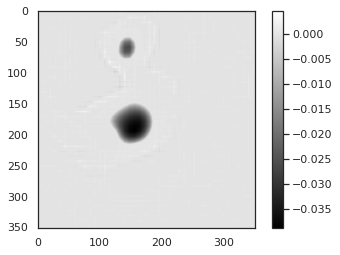

In [46]:
lam_len = len(lambdas_example_table)
lam_low = min(lambdas_example_table)
lam_high = max(lambdas_example_table)
fname_loss = f'.cache/{lam_low}_{lam_high}_{lam_len}_example_loss_table.npy'
fname_sizes = f'.cache/{lam_low}_{lam_high}_{lam_len}_example_size_table.npy'
try:
    loss_table = np.load(fname_loss)
    sizes_table = np.load(fname_sizes)
except:
    print("computing loss and size table")
    loss_table = np.zeros((regions.shape[0], lam_len))
    sizes_table = np.zeros((regions.shape[0], lam_len))
    for j in tqdm(range(lam_len)):
        est_regions = (regions >= -lambdas_example_table[j])
        print(type(est_regions),est_regions.shape,masks.shape)
        loss_table[:,j] = loss_perpolyp_01(est_regions, regions, masks) 
        sizes_table[:,j] = est_regions.sum(dim=1).sum(dim=1)/masks.sum(dim=1).sum(dim=1)

#     np.save(fname_loss, loss_table)
#     np.save(fname_sizes, sizes_table)


In [18]:
example_loss_table.shape,example_sizes_table.shape

((898, 500), (898, 500))